# DL Project

In [1]:
import h5py
import torch 
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys, os


# Set random seed for reproducibility
# manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


class_00084
class_00078
(1024,)
the filaments and anthers are prominent, rising above delicate yellow and white petals.



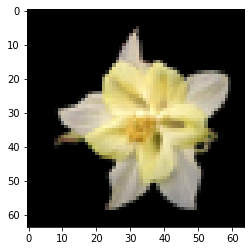

In [ ]:
# f = h5py.File('/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5','r')
# train_data = f['train']
# keys = list(train_data)
# list(f) 
# idx = random.randint(0,len(keys))
# idx2 = random.randint(0,len(keys))
# instance = f['train'][keys[idx]]
# inst2 = f['train'][keys[idx2]]
# print(instance['class'][()])
# print(inst2['class'][()])
# imgb = np.array(instance['img']).tobytes()
# print(np.array(instance['embeddings'],dtype=np.float).shape)
# print(instance['txt'][()])
# img = Image.open(io.BytesIO(imgb))
# # plt.subplot(2,1,1)
# # plt.imshow(img)
# # plt.subplot(2,1,2)
# # plt.imshow(Image.open(io.BytesIO(np.array(inst2['img']).tobytes())))
# img = img.resize((64,64),resample = 3)
# plt.imshow(img)
# plt.show()

In [3]:
class CustomDataset(Dataset):
    def __init__(self,file,splitType,transform=None):
        # splitType: train, test, val
        self.file = file
        self.transform = transform
        f = h5py.File(self.file,'r')
        self.dataset = f[splitType] ;# f.close()
        self.dkeys = list(self.dataset)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,index):
        inst_name = self.dkeys[index]
        inst = self.dataset[inst_name]

        rImg = (np.array(Image.open(io.BytesIO(np.array(inst['img']).tobytes())).convert("RGB").resize((64,64),resample = 3),dtype = np.float32) - 127.5)/127.5
        rImg = rImg.transpose(2,0,1)
        
        rEmbed = np.array(inst['embeddings'],dtype = float)
        randIndex = random.randint(0,len(self.dkeys)-1)
        while inst['class'][()] == self.dataset[self.dkeys[randIndex]]['class'][()]:
            randIndex = random.randint(0,len(self.dkeys)-1)    
        wImg = (np.array(Image.open(io.BytesIO(np.array(self.dataset[self.dkeys[randIndex]]['img']).tobytes())).convert("RGB").resize((64,64),resample = 3),dtype=np.float32) - 127.5)/127.5
        wImg = wImg.transpose(2,0,1)
        randIndex = random.randint(0,len(self.dkeys)-1)
        wEmbed = np.array(self.dataset[self.dkeys[randIndex]]['embeddings'],dtype = np.float32)


        txt = inst['txt'][()]
        special = u"\ufffd\ufffd"
        txt = txt.replace(special,' ')
        txt = str(np.array(txt).astype(str))

        dataPoint = {
                    'rImg': torch.FloatTensor(rImg),
                    'wImg': torch.FloatTensor(wImg),
                    'rEmbed': torch.FloatTensor(rEmbed),
                    'wEmbed': torch.FloatTensor(wEmbed),
                    'txt': txt 
                    }
        return dataPoint




In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.img_size = 64
        self.nc = 3
        self.ndim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.ndim + self.projected_embed_dim
        self.ngf = 64

        self.netProject = nn.Sequential(
            nn.Linear(in_features= self.embed_dim, out_features= self.projected_embed_dim),
            nn.BatchNorm1d(num_features = self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2,inplace = True)
        )

        self.netG = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( self.ngf, self.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self,embed ,noise):
        embed_projected = self.netProject(embed).unsqueeze(2).unsqueeze(3)
        latent = torch.cat([embed_projected,noise], 1)
        return self.netG(latent)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        """ model_type: 0-> DCGAN , 1-> WGAN
        """

        self.img_size = 64
        self.nc = 3
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.ndf = 64
        
        self.projector = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.netD1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.netD2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )     
          

    def forward(self, input,embed):
        x_int = self.netD1(input)
        x = self.projector(embed)
        rep_embed = x.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        x = torch.cat([x_int, rep_embed], 1)
        x = self.netD2(x)
        return x.view(-1,1).squeeze(1),x_int 


In [5]:
# Number of workers for dataloader
workers = 1
# Batch size during training
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
l1_rate = 50
l2_rate = 100

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [6]:
device

device(type='cpu')

In [16]:
model_type = 0 #0 -> dcgan , 1 -> gan_cls_int
pretrained = True

netG = Generator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
# print(netG)

netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
epoch = 0
if pretrained:
    if (os.path.exists('/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth') and model_type == 0):
        param_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
        print("Last Epoch: %d"%(param_dict['epoch']))
        netD.load_state_dict(param_dict['netD_state'])
        netG.load_state_dict(param_dict['netG_state'])
        epoch = param_dict['epoch']
        print('Parameters loaded')
    elif (os.path.exists('/content/drive/MyDrive/Colab Notebooks/modelState/gan_cls_int.pth') and model_type == 1):
        param_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/modelState/gan_cls_int.pth',map_location=device)
        print("Last Epoch: %d"%(param_dict['epoch']))
        netD.load_state_dict(param_dict['netD_state'])
        netG.load_state_dict(param_dict['netG_state'])
        epoch = param_dict['epoch']
        print('Parameters loaded')

    
# Print the model
# print(netD)
batch_size = 128 

Last Epoch: 0
Parameters loaded


In [17]:
dSet = CustomDataset(file = '/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5',splitType='train')
trainloader = DataLoader(dSet,batch_size = batch_size,shuffle=True,num_workers = 0)
dSet_test = CustomDataset(file = '/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5',splitType= 'test')
testloader = DataLoader(dSet_test,batch_size = 10 ,shuffle = True,num_workers = 0)



In [ ]:
# print(len(trainloader))
# print(len(dSet)/(64*5))

460
91.84375


In [ ]:
# Training Loop
# Initialize BCELoss function
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()workersworkers
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# Establish convention for real and fake labels during training
offset = 0.1
real_label = 1.
fake_label = 0.
smooth_real_label = real_label - offset
    
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = []

cls = False

print("Starting Training Loop...")
if model_type == 0:
    while epoch < num_epochs:
        epoch += 1
        for i, data in enumerate(trainloader, 0):
            # Training
            right_images = Variable(data['rImg'].float()).to(device)
            right_embeds  = Variable(data['rEmbed'].float()).to(device)
            wrong_images = Variable(data['wImg'].float()).to(device)
            real_labels  = torch.full((right_images.size(0),), smooth_real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((right_images.size(0),), fake_label,dtype=torch.float,device= device)

            # (1) Discriminator
            netD.zero_grad()
            outputs, real_activations = netD(right_images,right_embeds)
            real_loss = criterion(outputs,real_labels)
            real_score = outputs

            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, _ = netD(fake_images,right_embeds)
            fake_loss = criterion(outputs,fake_labels)
            fake_score = outputs

            netDLoss = real_loss + fake_loss
            if cls:
                outputs, _ = netD(wrong_images,right_embeds)
                wrong_loss = criterion(outputs,fake_labels)
                wrong_score = outputs
                netDLoss += wrong_loss 
            netDLoss.backward()
            optimizerD.step()

            # (2) Generator
            netG.zero_grad()
            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, fake_activations = netD(fake_images,right_embeds)

            real_activations = torch.mean(real_activations, 0)
            fake_activations = torch.mean(fake_activations, 0)

            netGLoss = criterion(outputs, real_labels) + l1_rate*l1_loss(fake_images,right_images) + l2_rate*l2_loss(fake_activations,real_activations.detach())
            netGLoss.backward()
            optimizerG.step()

            if i%10 == 0:
                print("Epoch %d, Iter: %d, netDLoss: %f, netGLoss: %f, D(X): %f, D(G(X)): %f"%(
                    epoch, i, netDLoss.cpu().mean(), netGLoss.cpu().mean(), real_score.cpu().mean(), fake_score.cpu().mean()
                ))
            iters.append(i)
            G_losses.append(netGLoss.cpu().mean())
            D_losses.append(netDLoss.cpu().mean())

        if (epoch)%2 == 0:
            param_dict = param_dict = { "netD_state": netD.state_dict(),
                                        "netG_state": netG.state_dict(),
                                    "epoch" : epoch
                                    }
            torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
            print("model Saved...")
elif (model_type == 1):
    cls = True
    INT = True
    beta_INT = 0.5
    while epoch < num_epochs:
        epoch += 1
        for i, data in enumerate(trainloader, 0):
            # Training
            right_images = Variable(data['rImg'].float()).to(device)
            right_embeds  = Variable(data['rEmbed'].float()).to(device)
            wrong_images = Variable(data['wImg'].float()).to(device)
            wrong_embeds = Variable(data['wEmbed'].float()).to(device)
            real_labels  = torch.full((right_images.size(0),), smooth_real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((right_images.size(0),), fake_label,dtype=torch.float,device= device)

            # (1) Discriminator
            netD.zero_grad()
            outputs, real_activations = netD(right_images,right_embeds)
            real_loss = criterion(outputs,real_labels)
            real_score = outputs

            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, _ = netD(fake_images,right_embeds)
            fake_loss = criterion(outputs,fake_labels)
            fake_score = outputs

            netDLoss = real_loss + fake_loss
            if cls:
                outputs, _ = netD(wrong_images,right_embeds)
                wrong_loss = criterion(outputs,fake_labels)
                wrong_score = outputs
                netDLoss += wrong_loss 
            netDLoss.backward()
            optimizerD.step()

            # (2) Generator
            netG.zero_grad()
            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)

            fake_images = netG(right_embeds,noise)
            outputs, fake_activations = netD(fake_images,right_embeds)  
            netGLoss = criterion(outputs, real_labels) + l1_rate*l1_loss(fake_images,right_images) + l2_rate*l2_loss(fake_activations,real_activations.detach())

            if (INT):
                gen_embed_input = beta_INT*right_embeds + (1 - beta_INT)*wrong_embeds
                fake_images_int = netG(gen_embed_input,noise)
                outputs_int, _ = netD(fake_images_int,right_embeds) 
                netGLoss += criterion(outputs_int,fake_labels) 

            netGLoss.backward()
            optimizerG.step()

            real_activations = torch.mean(real_activations, 0)
            fake_activations = torch.mean(fake_activations, 0)

            if i%10 == 0:
                print("Epoch %d, Iter: %d, netDLoss: %f, netGLoss: %f, D(X): %f, D(G(X)): %f"%(
                    epoch, i, netDLoss.cpu().mean(), netGLoss.cpu().mean(), real_score.cpu().mean(), fake_score.cpu().mean()
                ))
            iters.append(i)
            G_losses.append(netGLoss.cpu().mean())
            D_losses.append(netDLoss.cpu().mean())

        if (epoch)%2 == 0:
            param_dict = param_dict = { "netD_state": netD.state_dict(),
                                        "netG_state": netG.state_dict(),
                                    "epoch" : epoch
                                    }
            torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/gan_cls_int1.pth')
            print("model Saved...")

    

Starting Training Loop...
Epoch 19, Iter: 0, netDLoss: 1.548475, netGLoss: 51.443993, D(X): 0.357798, D(G(X)): 0.019068
Epoch 19, Iter: 10, netDLoss: 1.128309, netGLoss: 57.013859, D(X): 0.451805, D(G(X)): 0.026112
Epoch 19, Iter: 20, netDLoss: 1.325089, netGLoss: 51.113880, D(X): 0.374632, D(G(X)): 0.018687
Epoch 19, Iter: 30, netDLoss: 1.295409, netGLoss: 53.941502, D(X): 0.465663, D(G(X)): 0.024197
Epoch 19, Iter: 40, netDLoss: 1.721667, netGLoss: 54.481422, D(X): 0.284263, D(G(X)): 0.013896
Epoch 19, Iter: 50, netDLoss: 1.678143, netGLoss: 52.536320, D(X): 0.412945, D(G(X)): 0.022658
Epoch 19, Iter: 60, netDLoss: 1.385573, netGLoss: 52.513039, D(X): 0.396429, D(G(X)): 0.028072
Epoch 19, Iter: 70, netDLoss: 1.540949, netGLoss: 53.284794, D(X): 0.289006, D(G(X)): 0.013997
Epoch 19, Iter: 80, netDLoss: 1.397971, netGLoss: 49.677570, D(X): 0.493855, D(G(X)): 0.032726
Epoch 19, Iter: 90, netDLoss: 1.551836, netGLoss: 49.544891, D(X): 0.425474, D(G(X)): 0.023574
Epoch 19, Iter: 100, netD

In [ ]:
param_dict = {"netD_state": netD.state_dict(), 
              "netG_state": netG.state_dict(),
              "epoch": 0}
if model_type == 0:              
    torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
elif model_type == 1:
    torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/gan_cls_int.pth')

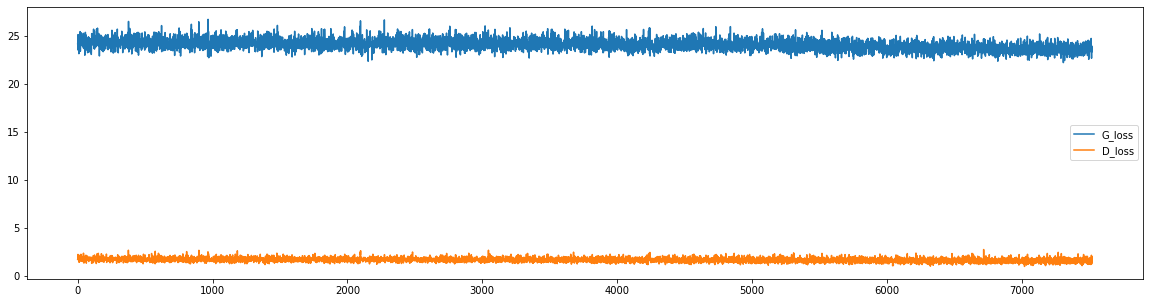

In [ ]:
iters = [i for i in range(len(iters))]
part1, =  plt.plot(iters[0:len(G_losses)],G_losses,label = "G_loss")
part2, = plt.plot(iters[0:len(G_losses)],D_losses,label = "D_loss")
plt.legend()
plt.show()

In [ ]:
# param_dict = {"netD_state": netD.state_dict(),
#               "netG_state": netG.state_dict()}
# torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

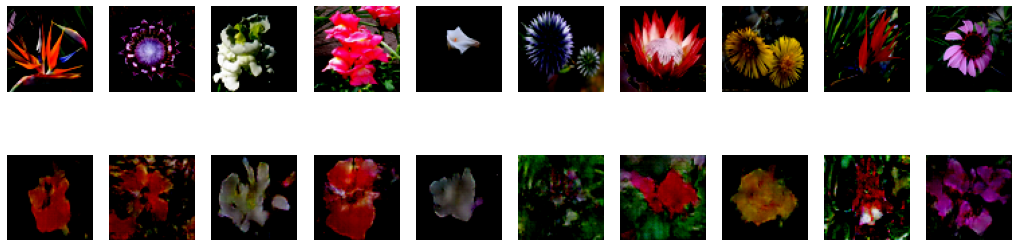

In [20]:
# Testing
val = next(enumerate(testloader))[1]
imgTrue = val['rImg'].numpy()
captions = val['txt']
nexam = 10
with torch.no_grad():
    noise = torch.randn((val['rImg'].size(0),100),device = device)
    noise = noise.view(noise.size(0),100,1,1).to(device)
    fake_images = netG(Variable(val['rEmbed'].float()).to(device),noise).cpu().numpy()

plt.rcParams["figure.figsize"] = (18,5)
for i in range(nexam):
    GT = imgTrue[i].transpose(1,2,0)
    Gen = fake_images[i].transpose(1,2,0)
    plt.subplot(2,nexam,i+1)
    plt.axis('off')
    plt.imshow(GT)
    plt.subplot(2,nexam,i+1+nexam)
    plt.axis('off')
    plt.imshow(Gen)
plt.show()